<a href="https://colab.research.google.com/github/Jerrin-rajans/Coronavirus_India/blob/master/Using_Prophet_Predicting_Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
upload = files.upload()

Saving novel-corona-virus-2019-dataset.zip to novel-corona-virus-2019-dataset.zip


In [2]:
!unzip *.zip

Archive:  novel-corona-virus-2019-dataset.zip
  inflating: COVID19_line_list_data.csv  
  inflating: COVID19_open_line_list.csv  
  inflating: covid_19_data.csv       
  inflating: time_series_covid_19_confirmed.csv  
  inflating: time_series_covid_19_deaths.csv  
  inflating: time_series_covid_19_recovered.csv  


In [3]:
!pip install pycountry

     |████████████████████████████████| 10.0MB 65kB/s 
  Created wheel for pycountry: filename=pycountry-19.8.18-py2.py3-none-any.whl size=10627361 sha256=66a059cfb7f6d66a49b073eca359c162ca2cf8a7d03886aeef9d6570cf28eec0
  Stored in directory: /root/.cache/pip/wheels/a2/98/bf/f0fa1c6bf8cf2cbdb750d583f84be51c2cd8272460b8b36bd3
Successfully built pycountry


 https://www.cdc.gov/coronavirus/2019-ncov/faq.html

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from fbprophet import Prophet
import pycountry
import plotly.express as px
from collections import namedtuple

Reading of Data set from  
Johns Hopkins University for making the data available for educational and academic research purposes
MoBS lab - https://www.mobs-lab.org/2019ncov.html
World Health Organization (WHO): https://www.who.int/
DXY.cn. Pneumonia. 2020. http://3g.dxy.cn/newh5/view/pneumonia.
BNO News: https://bnonews.com/index.php/2020/02/the-latest-coronavirus-cases/
National Health Commission of the People’s Republic of China (NHC): http://www.nhc.gov.cn/xcs/yqtb/list_gzbd.shtml
China CDC (CCDC): http://weekly.chinacdc.cn/news/TrackingtheEpidemic.htm
Hong Kong Department of Health: https://www.chp.gov.hk/en/features/102465.html
Macau Government: https://www.ssm.gov.mo/portal/
Taiwan CDC: https://sites.google.com/cdc.gov.tw/2019ncov/taiwan?authuser=0
US CDC: https://www.cdc.gov/coronavirus/2019-ncov/index.html
Government of Canada: https://www.canada.ca/en/public-health/services/diseases/coronavirus.html
Australia Government Department of Health: https://www.health.gov.au/news/coronavirus-update-at-a-glance
European Centre for Disease Prevention and Control (ECDC): https://www.ecdc.europa.eu/en/geographical-distribution-2019-ncov-cases
Ministry of Health Singapore (MOH): https://www.moh.gov.sg/covid-19
Italy Ministry of Health: http://www.salute.gov.it/nuovocoronavirus

In [0]:
df = pd.read_csv('covid_19_data.csv',parse_dates=['Last Update'])#covid_19_data.csv
df.rename(columns={'ObservationDate':'Date', 'Country/Region':'Country'}, inplace=True)

df_confirmed = pd.read_csv("time_series_covid_19_confirmed.csv")#time_series_covid_19_confirmed.csv
df_recovered = pd.read_csv("time_series_covid_19_recovered.csv")#time_series_covid_19_deaths.csv
df_deaths = pd.read_csv("time_series_covid_19_deaths.csv")#time_series_covid_19_recovered.csv

df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
df_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
df_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)

In [62]:
df_confirmed.head()

,Province/State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5


In [63]:
df.head()

,SNo,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


In [64]:
df.tail()

,SNo,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
9730,9731,03/28/2020,Wyoming,US,2020-03-28 23:11:06,82.0,0.0,0.0
9731,9732,03/28/2020,Xinjiang,Mainland China,2020-03-28 23:11:06,76.0,3.0,73.0
9732,9733,03/28/2020,Yukon,Canada,2020-03-28 23:11:06,4.0,0.0,0.0
9733,9734,03/28/2020,Yunnan,Mainland China,2020-03-28 23:11:06,180.0,2.0,172.0
9734,9735,03/28/2020,Zhejiang,Mainland China,2020-03-28 23:11:06,1251.0,1.0,1225.0


In [0]:
df2 = df.groupby(["Date", "Country", "Province/State"])[['SNo', 'Date', 'Province/State', 'Country', 'Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

In [66]:
df2

,Date,Country,Province/State,SNo,Confirmed,Deaths,Recovered
0,01/22/2020,Hong Kong,Hong Kong,13,0.0,0.0,0.0
1,01/22/2020,Macau,Macau,21,1.0,0.0,0.0
2,01/22/2020,Mainland China,Anhui,1,1.0,0.0,0.0
3,01/22/2020,Mainland China,Beijing,2,14.0,0.0,0.0
4,01/22/2020,Mainland China,Chongqing,3,6.0,0.0,0.0
...,...,...,...,...,...,...,...
5293,03/28/2020,US,Virginia,9726,740.0,13.0,0.0
5294,03/28/2020,US,Washington,9727,4030.0,188.0,0.0
5295,03/28/2020,US,West Virginia,9728,96.0,0.0,0.0
5296,03/28/2020,US,Wisconsin,9730,1055.0,17.0,0.0


In [67]:
df.query('Country=="Mainland China"').groupby("Last Update")[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22 17:00:00,547.0,17.0,28.0
1,2020-01-23 17:00:00,639.0,18.0,30.0
2,2020-01-24 17:00:00,916.0,26.0,36.0
3,2020-01-25 17:00:00,1399.0,42.0,39.0
4,2020-01-26 16:00:00,2062.0,56.0,49.0
...,...,...,...,...
786,2020-03-24 23:41:50,81180.0,3277.0,73169.0
787,2020-03-25 23:37:49,81221.0,3281.0,73661.0
788,2020-03-26 23:53:24,81298.0,3287.0,74061.0
789,2020-03-27 23:27:48,81345.0,3292.0,74600.0


In [68]:
df.groupby("Country")[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

,Country,Confirmed,Deaths,Recovered
0,Azerbaijan,1.0,0.0,0.0
1,"('St. Martin',)",2.0,0.0,0.0
2,Afghanistan,761.0,17.0,17.0
3,Albania,1554.0,55.0,112.0
4,Algeria,3017.0,214.0,480.0
...,...,...,...,...
207,Vietnam,2327.0,0.0,680.0
208,West Bank and Gaza,273.0,3.0,52.0
209,Zambia,95.0,0.0,0.0
210,Zimbabwe,31.0,6.0,0.0


In [75]:
df.groupby('Date').sum()

,SNo,Confirmed,Deaths,Recovered
Date,,,,
01/22/2020,741,555.0,17.0,28.0
01/23/2020,2829,653.0,18.0,30.0
01/24/2020,4305,941.0,26.0,36.0
01/25/2020,6490,1438.0,42.0,39.0
01/26/2020,9071,2118.0,56.0,52.0
...,...,...,...,...
03/24/2020,2499640,417966.0,18615.0,107705.0
03/25/2020,2615471,467594.0,21181.0,113770.0
03/26/2020,2743137,529591.0,23970.0,122150.0


In [0]:
confirmed = df.groupby('Date').sum()['Confirmed'].reset_index()
deaths = df.groupby('Date').sum()['Deaths'].reset_index()
recovered = df.groupby('Date').sum()['Recovered'].reset_index()

In [77]:
fig = go.Figure()
fig.add_trace(go.Bar(x=confirmed['Date'],
                y=confirmed['Confirmed'],
                name='Confirmed',
                marker_color='blue'
                ))
fig.add_trace(go.Bar(x=deaths['Date'],
                y=deaths['Deaths'],
                name='Deaths',
                marker_color='Red'
                ))
fig.add_trace(go.Bar(x=recovered['Date'],
                y=recovered['Recovered'],
                name='Recovered',
                marker_color='Green'
                ))

fig.update_layout(
    title='Worldwide Corona Virus Cases - Confirmed, Deaths, Recovered (Bar Chart)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Number of Cases',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

In [78]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=confirmed['Date'], 
                         y=confirmed['Confirmed'],
                         mode='lines+markers',
                         name='Confirmed',
                         line=dict(color='blue', width=2)
                        ))
fig.add_trace(go.Scatter(x=deaths['Date'], 
                         y=deaths['Deaths'],
                         mode='lines+markers',
                         name='Deaths',
                         line=dict(color='Red', width=2)
                        ))
fig.add_trace(go.Scatter(x=recovered['Date'], 
                         y=recovered['Recovered'],
                         mode='lines+markers',
                         name='Recovered',
                         line=dict(color='Green', width=2)
                        ))
fig.update_layout(
    title='Worldwide Corona Virus Cases - Confirmed, Deaths, Recovered (Line Chart)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Number of Cases',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    )
)
fig.show()


In [0]:
df_confirmed = df_confirmed[["Province/State","Lat","Long","Country"]]
df_temp = df.copy()
df_temp['Country'].replace({'Mainland China': 'China'}, inplace=True)
df_latlong = pd.merge(df_temp, df_confirmed, on=["Country", "Province/State"])

In [80]:
fig = px.density_mapbox(df_latlong, 
                        lat="Lat", 
                        lon="Long", 
                        hover_name="Province/State", 
                        hover_data=["Confirmed","Deaths","Recovered"], 
                        animation_frame="Date",
                        color_continuous_scale="Portland",
                        radius=7, 
                        zoom=0,height=700)
fig.update_layout(title='Worldwide Corona Virus Cases Time Lapse - Confirmed, Deaths, Recovered',
                  font=dict(family="Courier New, monospace",
                            size=18,
                            color="#7f7f7f")
                 )
fig.update_layout(mapbox_style="open-street-map", mapbox_center_lon=0)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


fig.show()

In [0]:
confirmed = df2.groupby(['Date', 'Country']).sum()[['Confirmed']].reset_index()
deaths = df2.groupby(['Date', 'Country']).sum()[['Deaths']].reset_index()
recovered = df2.groupby(['Date', 'Country']).sum()[['Recovered']].reset_index()

In [82]:
latest_date = confirmed['Date'].max()
latest_date

'03/28/2020'

In [0]:
confirmed = confirmed[(confirmed['Date']==latest_date)][['Country', 'Confirmed']]
deaths = deaths[(deaths['Date']==latest_date)][['Country', 'Deaths']]
recovered = recovered[(recovered['Date']==latest_date)][['Country', 'Recovered']]

In [84]:
all_countries = confirmed['Country'].unique()
print("Number of countries/regions with cases: " + str(len(all_countries)))
print("Countries/Regions with cases: ")
for i in all_countries:
    print("    " + str(i))

Number of countries/regions with cases: 10
Countries/Regions with cases: 
    Australia
    Canada
    Denmark
    France
    Hong Kong
    Macau
    Mainland China
    Netherlands
    UK
    US


In [85]:
print(list(country.name for country in pycountry.countries))

['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Åland Islands', 'Albania', 'Andorra', 'United Arab Emirates', 'Argentina', 'Armenia', 'American Samoa', 'Antarctica', 'French Southern Territories', 'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Bonaire, Sint Eustatius and Saba', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas', 'Bosnia and Herzegovina', 'Saint Barthélemy', 'Belarus', 'Belize', 'Bermuda', 'Bolivia, Plurinational State of', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan', 'Bouvet Island', 'Botswana', 'Central African Republic', 'Canada', 'Cocos (Keeling) Islands', 'Switzerland', 'Chile', 'China', "Côte d'Ivoire", 'Cameroon', 'Congo, The Democratic Republic of the', 'Congo', 'Cook Islands', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Cuba', 'Curaçao', 'Christmas Island', 'Cayman Islands', 'Cyprus', 'Czechia', 'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egy

In [86]:
print('UK' in list(country.name for country in pycountry.countries))
print('United Kingdom' in list(country.name for country in pycountry.countries))

False
True


In [0]:
confirmed2 = confirmed.copy()
deaths2 = deaths.copy()
recovered2 = recovered.copy()
bubble_plot_dfs = [confirmed2, deaths2, recovered2]
for df_ in bubble_plot_dfs:
    df_["Country"].replace({'Mainland China': 'China'}, inplace=True)
    df_["Country"].replace({'UK': 'United Kingdom'}, inplace=True)
    df_["Country"].replace({'US': 'United States'}, inplace=True)

In [0]:
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3
    
confirmed2["iso_alpha"] = confirmed2["Country"].map(countries.get)
deaths2["iso_alpha"] = deaths2["Country"].map(countries.get)
recovered2["iso_alpha"] = recovered2["Country"].map(countries.get)

In [0]:
plot_data_confirmed = confirmed2[["iso_alpha","Confirmed", "Country"]]
plot_data_deaths = deaths2[["iso_alpha","Deaths"]]
plot_data_recovered = recovered2[["iso_alpha","Recovered"]]

In [90]:
fig = px.scatter_geo(plot_data_confirmed, locations="iso_alpha", color="Country",
                     hover_name="iso_alpha", size="Confirmed",
                     projection="natural earth", title = 'Worldwide Confirmed Cases')
fig.show()

In [91]:
fig = px.scatter_geo(plot_data_deaths, locations="iso_alpha", color="Deaths",
                     hover_name="iso_alpha", size="Deaths",
                     projection="natural earth", title="Worldwide Death Cases")
fig.show()

In [92]:
fig = px.scatter_geo(plot_data_recovered, locations="iso_alpha", color="Recovered",
                     hover_name="iso_alpha", size="Recovered",
                     projection="natural earth", title="Worldwide Recovered Cases")
fig.show()

In [0]:
confirmed = df.groupby('Date').sum()['Confirmed'].reset_index()
deaths = df.groupby('Date').sum()['Deaths'].reset_index()
recovered = df.groupby('Date').sum()['Recovered'].reset_index()

In [0]:
confirmed.columns = ['ds','y']
#confirmed['ds'] = confirmed['ds'].dt.date
confirmed['ds'] = pd.to_datetime(confirmed['ds'])

In [95]:
confirmed.head()

,ds,y
0,2020-01-22,555.0
1,2020-01-23,653.0
2,2020-01-24,941.0
3,2020-01-25,1438.0
4,2020-01-26,2118.0


In [96]:
m = Prophet(interval_width=0.95)
m.fit(confirmed)
future = m.make_future_dataframe(periods=7)
future_confirmed = future.copy() # for non-baseline predictions later on
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
69,2020-03-31
70,2020-04-01
71,2020-04-02
72,2020-04-03
73,2020-04-04


In [97]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
69,2020-03-31,602862.012660,551855.147039,654591.154917
70,2020-04-01,631142.357390,578357.685118,680900.043719
71,2020-04-02,661606.328778,608290.046068,713914.022239
72,2020-04-03,690786.962287,640628.627980,745135.268793
73,2020-04-04,719752.388972,663488.911610,773767.121775


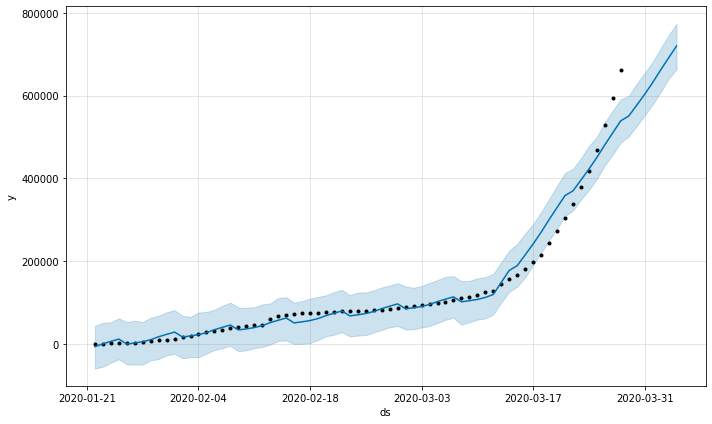

In [98]:
confirmed_forecast_plot = m.plot(forecast)

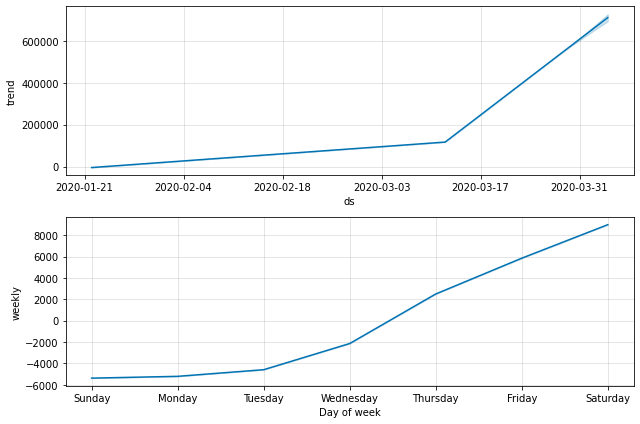

In [99]:
forecast_components = m.plot_components(forecast)

In [0]:
deaths.columns = ['ds','y']
deaths['ds'] = pd.to_datetime(deaths['ds'])

In [101]:
m = Prophet(interval_width=0.95)
m.fit(deaths)
future = m.make_future_dataframe(periods=7)
future_deaths = future.copy() # for non-baseline predictions later on
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
69,2020-03-31
70,2020-04-01
71,2020-04-02
72,2020-04-03
73,2020-04-04


In [102]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
69,2020-03-31,29897.023063,28086.272407,31879.478220
70,2020-04-01,31532.634306,29501.766716,33494.659187
71,2020-04-02,33132.453324,30938.105691,35287.594446
72,2020-04-03,34847.400512,32760.831717,36898.354277
73,2020-04-04,36602.725483,34387.396755,38716.268775


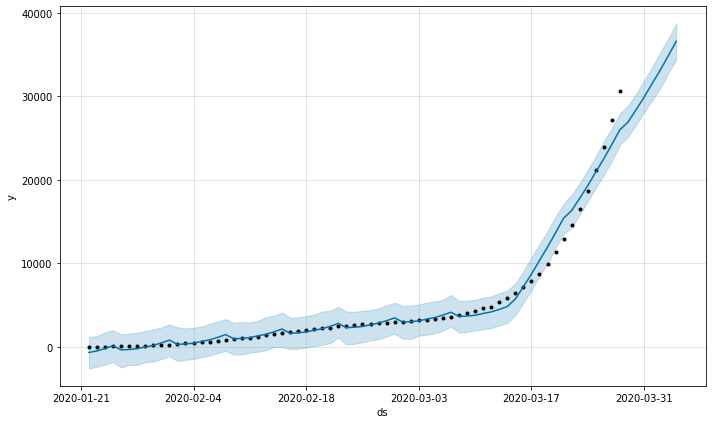

In [103]:
deaths_forecast_plot = m.plot(forecast)

In [0]:
recovered.columns = ['ds','y']
recovered['ds'] = pd.to_datetime(recovered['ds'])

In [105]:
m = Prophet(interval_width=0.95)
m.fit(recovered)
future = m.make_future_dataframe(periods=7)
future_recovered = future.copy() # for non-baseline predictions later on
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
69,2020-03-31
70,2020-04-01
71,2020-04-02
72,2020-04-03
73,2020-04-04


In [106]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
69,2020-03-31,136331.896016,130458.552737,142041.920368
70,2020-04-01,140462.367835,134633.839910,146770.518723
71,2020-04-02,144451.783549,138707.907884,151008.574512
72,2020-04-03,148524.993966,142021.761624,154497.977381
73,2020-04-04,153097.317732,147245.153133,159756.035203


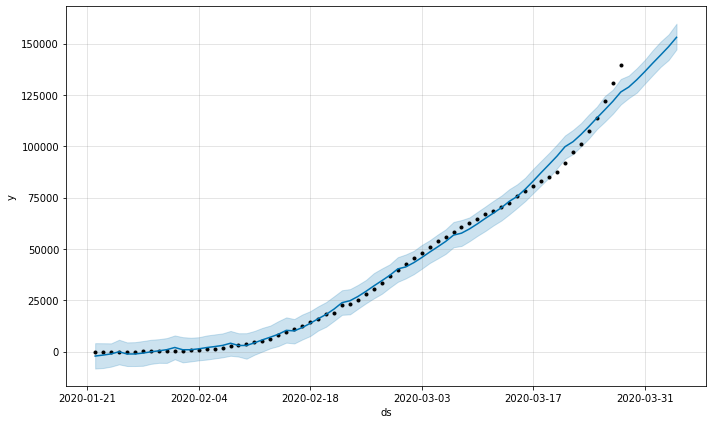

In [107]:
recovered_forecast_plot = m.plot(forecast)

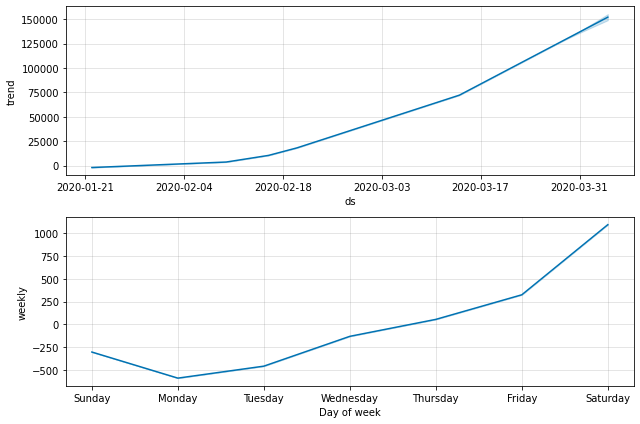

In [108]:
forecast_components = m.plot_components(forecast)

In [109]:
days_to_forecast = 14 # changable
first_forecasted_date = sorted(list(set(df2['Date'].values)))[-days_to_forecast]

print('The first date to perform forecasts for is: ' + str(first_forecasted_date))

The first date to perform forecasts for is: 03/15/2020


In [110]:
confirmed_df = df2[['SNo', 'Date','Province/State', 'Country', 'Confirmed']]
confirmed_df

,SNo,Date,Province/State,Country,Confirmed
0,13,01/22/2020,Hong Kong,Hong Kong,0.0
1,21,01/22/2020,Macau,Macau,1.0
2,1,01/22/2020,Anhui,Mainland China,1.0
3,2,01/22/2020,Beijing,Mainland China,14.0
4,3,01/22/2020,Chongqing,Mainland China,6.0
...,...,...,...,...,...
5293,9726,03/28/2020,Virginia,US,740.0
5294,9727,03/28/2020,Washington,US,4030.0
5295,9728,03/28/2020,West Virginia,US,96.0
5296,9730,03/28/2020,Wisconsin,US,1055.0


In [111]:
deaths_df = df2[['SNo', 'Date','Province/State', 'Country', 'Deaths']]
deaths_df

,SNo,Date,Province/State,Country,Deaths
0,13,01/22/2020,Hong Kong,Hong Kong,0.0
1,21,01/22/2020,Macau,Macau,0.0
2,1,01/22/2020,Anhui,Mainland China,0.0
3,2,01/22/2020,Beijing,Mainland China,0.0
4,3,01/22/2020,Chongqing,Mainland China,0.0
...,...,...,...,...,...
5293,9726,03/28/2020,Virginia,US,13.0
5294,9727,03/28/2020,Washington,US,188.0
5295,9728,03/28/2020,West Virginia,US,0.0
5296,9730,03/28/2020,Wisconsin,US,17.0


In [112]:
recovered_df = df2[['SNo', 'Date','Province/State', 'Country', 'Recovered']]
recovered_df

,SNo,Date,Province/State,Country,Recovered
0,13,01/22/2020,Hong Kong,Hong Kong,0.0
1,21,01/22/2020,Macau,Macau,0.0
2,1,01/22/2020,Anhui,Mainland China,0.0
3,2,01/22/2020,Beijing,Mainland China,0.0
4,3,01/22/2020,Chongqing,Mainland China,0.0
...,...,...,...,...,...
5293,9726,03/28/2020,Virginia,US,0.0
5294,9727,03/28/2020,Washington,US,0.0
5295,9728,03/28/2020,West Virginia,US,0.0
5296,9730,03/28/2020,Wisconsin,US,0.0


In [0]:
def make_forecasts(all_countries, confirmed_df, deaths_df, recovered_df, days_to_forecast, first_forecasted_date, mode):
    forecast_dfs = []
    absolute_errors = [] # collate absolute errors so that we can find MAE later on
    counter = 0 # arbitrary counter to output snippet of result_val_df only once, when it is 1
    for country in all_countries:
        try:
            assert(country in confirmed_df['Country'].values)
            print('Country ' + str(country) + ' is listed! ')
            country_confirmed_df = confirmed_df[(confirmed_df['Country'] == country)]
            country_deaths_df = deaths_df[(deaths_df['Country'] == country)]
            country_recovered_df = recovered_df[(recovered_df['Country'] == country)]
            country_dfs = [('Confirmed', country_confirmed_df), 
                           ('Deaths', country_deaths_df), 
                           ('Recovered', country_recovered_df)]
            states_in_country = country_confirmed_df['Province/State'].unique()
            for state in states_in_country:
                try:
                    state_dfs = [] # to store forecasts for Confirmed, Deaths and Recovered

                    assert(state in country_confirmed_df['Province/State'].values)

                    # make forecasts for each case type (Confirmed, Deaths, Recovered)
                    for country_df_tup in country_dfs:
                        case_type = country_df_tup[0]
                        country_df = country_df_tup[1]
                        state_df = country_df[(country_df['Province/State'] == state)]

                        # data preparation for forecast with Prophet at state level
                        state_df = state_df[['Date', case_type]]
                        state_df.columns = ['ds','y']
                        state_df['ds'] = pd.to_datetime(state_df['ds'])

                        state_df_val = state_df[(state_df['ds'] >= pd.to_datetime(first_forecasted_date))] # validation set
                        state_df = state_df[(state_df['ds'] < pd.to_datetime(first_forecasted_date))] # train set

                        if mode == 'default':
                            m = Prophet()
                        elif mode == 'custom':
                            m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
                            m.add_seasonality(name='monthly', period=30.5, fourier_order=7)
                            m.add_seasonality(name='weekly', period=7, fourier_order=30)
                            m.add_seasonality(name='daily', period=1, fourier_order=1)
                        m.fit(state_df)
                        future = m.make_future_dataframe(periods=days_to_forecast)
                        forecast = m.predict(future)

                        # evaluate forecasts with validation set and save absolute errors to absolute_errors
                        forecast_df = forecast[['ds', 'yhat']]
                        result_df = forecast_df[(forecast_df['ds'] >= pd.to_datetime(first_forecasted_date))]
                        result_val_df = result_df.merge(state_df_val, on=['ds'])
                        result_val_df['abs_diff'] = (result_val_df['y'] - result_val_df['yhat']).abs()
                        absolute_errors += list(result_val_df['abs_diff'].values)

                        # the following allows the user to check the output at particular checkpoints. Feel free to change!
                        if counter == 1:
                            print('Printing snippet of result_val_df: \n')
                            print(result_val_df)
                            print(absolute_errors)
                        counter += 1

                        # save results to dataframe
                        forecast_df['Province/State'] = state
                        forecast_df['Country/Region'] = country
                        forecast_df.rename(columns={'yhat':case_type}, inplace=True)
                        state_dfs += [forecast_df.tail(days_to_forecast)]

                    merged_df = state_dfs[0].merge(state_dfs[1],on=['ds', 'Province/State', 'Country/Region']).merge(state_dfs[2],on=['ds', 'Province/State', 'Country/Region'])
                    forecast_dfs += [merged_df]
                except:
                    continue
        except:
            print('Country ' + str(country) + ' is not listed! ')
            continue
    results_tup = namedtuple('results_tup', ['forecast_dfs', 'absolute_errors'])
    return results_tup(forecast_dfs, absolute_errors)

In [0]:
forecast_results = make_forecasts(all_countries, confirmed_df, deaths_df, recovered_df, days_to_forecast, first_forecasted_date, 'default')
absolute_errors = forecast_results.absolute_errors

In [53]:
forecast_results.forecast_dfs[0].tail(days_to_forecast) # example of a forecast

,ds,Confirmed,Province/State,Country/Region,Deaths,Recovered
0,2020-03-22,137.234967,New South Wales,Australia,2.837242,5.025722
1,2020-03-23,153.796278,New South Wales,Australia,3.012989,4.797277
2,2020-03-24,160.443049,New South Wales,Australia,3.138211,4.797116
3,2020-03-25,169.963631,New South Wales,Australia,3.388461,4.796968
4,2020-03-26,174.984294,New South Wales,Australia,3.388625,5.296811
5,2020-03-27,184.628700,New South Wales,Australia,3.513820,5.296671
6,2020-03-28,197.773046,New South Wales,Australia,3.513973,5.296531


In [54]:
forecasts_final = pd.concat(forecast_results.forecast_dfs, axis=0)
forecasts_final.sort_values(by='ds')
forecasts_final = forecasts_final[['ds', 'Province/State', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
forecasts_final.rename(columns={'ds':'ObservationDate'}, inplace=True)
for case_type in ['Confirmed', 'Deaths', 'Recovered']:
    forecasts_final[case_type] = forecasts_final[case_type].round() # round forecasts to integer as humans cannot be floats
    forecasts_final[forecasts_final[case_type] < 0] = 0 # replace negative forecasts to zero

forecasts_final

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-03-22 00:00:00,New South Wales,Australia,137.0,3.0,5.0
1,2020-03-23 00:00:00,New South Wales,Australia,154.0,3.0,5.0
2,2020-03-24 00:00:00,New South Wales,Australia,160.0,3.0,5.0
3,2020-03-25 00:00:00,New South Wales,Australia,170.0,3.0,5.0
4,2020-03-26 00:00:00,New South Wales,Australia,175.0,3.0,5.0
...,...,...,...,...,...,...
2,2020-03-24 00:00:00,United States Virgin Islands,US,9.0,0.0,0.0
3,2020-03-25 00:00:00,United States Virgin Islands,US,10.0,0.0,0.0
4,2020-03-26 00:00:00,United States Virgin Islands,US,12.0,0.0,0.0
5,2020-03-27 00:00:00,United States Virgin Islands,US,13.0,0.0,0.0


In [55]:
forecast_results_custom = make_forecasts(all_countries, confirmed_df, deaths_df, recovered_df, days_to_forecast, first_forecasted_date, 'custom')
absolute_errors_custom = forecast_results_custom.absolute_errors
forecast_dfs_custom = forecast_results_custom.forecast_dfs


Country Australia is listed! 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

Printing snippet of result_val_df: 

          ds      yhat    y  abs_diff
0 2020-03-22  2.633565  6.0  3.366435
1 2020-03-23  1.846836  6.0  4.153164
2 2020-03-24  1.580634  7.0  5.419366
3 2020-03-25  2.000547  7.0  4.999453
4 2020-03-26  2.293253  7.0  4.706747
5 2020-03-27  2.637400  7.0  4.362600
6 2020-03-28  2.920001  8.0  5.079999
[386.88422124845613, 420.69055420649875, 564.183711683432, 736.757894669676, 896.4739236770545, 1068.5479130421052, 1270.6069732812543, 3.36643509875901, 4.153164287579399, 5.419366140623005, 4.9994525298067165, 4.706747155117407, 4.362599678645247, 5.079998548856185]


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Country Canada is listed! 


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbpro

Country Denmark is listed! 


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Country France is listed! 


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbproph

Country Hong Kong is listed! 
Country Macau is listed! 
Country Mainland China is listed! 


INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


Country Netherlands is listed! 


INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Country UK is listed! 


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbproph

Country US is listed! 


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

In [56]:
forecasts_final_custom = pd.concat(forecast_dfs_custom, axis=0)
forecasts_final_custom.sort_values(by='ds')
forecasts_final_custom = forecasts_final_custom[['ds', 'Province/State', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
forecasts_final_custom.rename(columns={'ds':'ObservationDate'}, inplace=True)
for case_type in ['Confirmed', 'Deaths', 'Recovered']:
    forecasts_final_custom[case_type] = forecasts_final_custom[case_type].round() # round forecasts to integer as humans cannot be floats
    forecasts_final_custom[forecasts_final_custom[case_type] < 0] = 0 # replace negative forecasts to zero

forecasts_final_custom

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-03-22 00:00:00,New South Wales,Australia,282.0,3.0,4.0
1,2020-03-23 00:00:00,New South Wales,Australia,248.0,2.0,3.0
2,2020-03-24 00:00:00,New South Wales,Australia,254.0,2.0,4.0
3,2020-03-25 00:00:00,New South Wales,Australia,292.0,2.0,4.0
4,2020-03-26 00:00:00,New South Wales,Australia,323.0,2.0,4.0
...,...,...,...,...,...,...
2,2020-03-24 00:00:00,United States Virgin Islands,US,47.0,0.0,0.0
3,2020-03-25 00:00:00,United States Virgin Islands,US,123.0,0.0,0.0
4,2020-03-26 00:00:00,United States Virgin Islands,US,21.0,0.0,0.0
5,0,0,0,0.0,0.0,0.0


In [0]:
forecasts_final_custom.to_csv("forecasts_custom_prophet.csv", index=False) # save forecasts to CSV

In [58]:
N = len(absolute_errors)
mean_absolute_error = sum(absolute_errors)/N
print('The mean absolute error for ' + str(days_to_forecast) + ' days of forecasts with the default Prophet model is: ' + str(round(mean_absolute_error, 2))) # round to 2 decimal places

The mean absolute error for 7 days of forecasts with the default Prophet model is: 185.03


In [59]:
mean_absolute_error_custom = sum(absolute_errors_custom)/N
print('The mean absolute error for ' + str(days_to_forecast) + ' days of forecasts with the custom Prophet model is: ' + str(round(mean_absolute_error_custom, 2))) # round to 2 decimal places

The mean absolute error for 7 days of forecasts with the custom Prophet model is: 771.2


In [0]:
f = pd.read_csv('forecasts_custom_prophet.csv')

In [71]:
f.head()

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-03-22 00:00:00,New South Wales,Australia,282.0,3.0,4.0
1,2020-03-23 00:00:00,New South Wales,Australia,248.0,2.0,3.0
2,2020-03-24 00:00:00,New South Wales,Australia,254.0,2.0,4.0
3,2020-03-25 00:00:00,New South Wales,Australia,292.0,2.0,4.0
4,2020-03-26 00:00:00,New South Wales,Australia,323.0,2.0,4.0


In [72]:
f.tail()

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
1808,2020-03-24 00:00:00,United States Virgin Islands,US,47.0,0.0,0.0
1809,2020-03-25 00:00:00,United States Virgin Islands,US,123.0,0.0,0.0
1810,2020-03-26 00:00:00,United States Virgin Islands,US,21.0,0.0,0.0
1811,0,0,0,0.0,0.0,0.0
1812,0,0,0,0.0,0.0,0.0


In [73]:
f.columns

Index(['ObservationDate', 'Province/State', 'Country/Region', 'Confirmed',
       'Deaths', 'Recovered'],
      dtype='object')

In [74]:
max(f['ObservationDate'])

'2020-03-28 00:00:00'